In [1]:
import polars as pl

# データ準備

## load data

In [2]:
df = pl.read_csv("HostLogons-demo.csv")
df = df.with_columns(pl.col("Date").str.strptime(pl.Date, fmt = "%m/%d/%Y"))
df.head()

Date,EventId,AccountNtdomain,ComputerName,logontype,TotalLogons
date,str,str,str,i64,i64
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",10,2
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",3,106
2018-01-03,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",4,68
2018-01-04,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",3,53
2018-01-04,"""Microsoft-Wind...","""LABDOMAIN.LOCA...","""WIN-DC01""",4,89


## data preprocessing

In [3]:
tmp = df.groupby("Date").agg([pl.col("TotalLogons").sum().alias("n_events")]).sort("Date")

In [4]:
tmp.head()

Date,n_events
date,i64
2018-01-03,176
2018-01-04,142
2018-01-05,85
2018-01-06,147
2018-01-07,142


## plot date

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xfq7mqmy because the default path (/home/work/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<Axes: xlabel='Date', ylabel='n_events'>

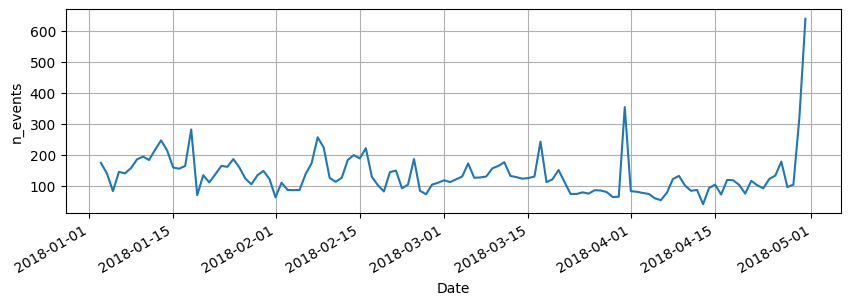

In [6]:
plt.rcParams["figure.figsize"] = (10,3)

plt.grid()
plt.gcf().autofmt_xdate()
sns.lineplot(tmp, x = "Date", y= "n_events", legend="full")

## データ確認

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

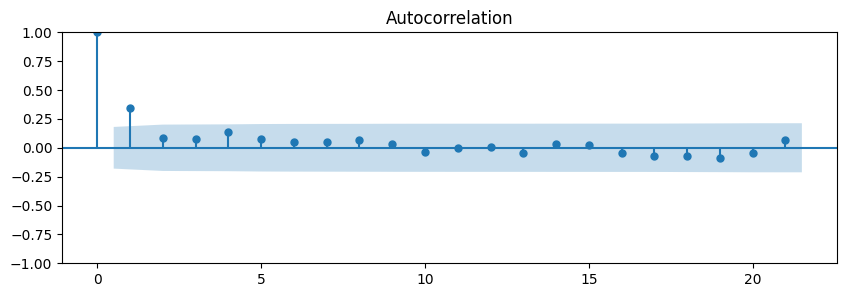

In [11]:
plot_acf(tmp.get_column("n_events").to_numpy(), missing = "drop");

# model

In [7]:
from sktime.forecasting.fbprophet import Prophet

In [ ]:
model = Prophet(
    

)